In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [2]:
def plot_actual_vs_pred(actual, pred, title, levels = [25,50,100], filename = 'a', save = False):
    gas = ['NO', 'NO_2', 'NH_3']
    fig, axs = plt.subplots(1,3, figsize=(20, 20/3), sharex=True, sharey=True)
    fig.suptitle(title, fontsize=30)
    for i, ax in enumerate(axs.flat):
        ax.scatter(actual[:,i], pred[:,i], color = 'red')
        ax.set_title(f'${gas[i]}$', fontsize = 15)
        ax.set_ylabel('Predicted', fontsize = 20)
        ax.set_xlabel('Actual', fontsize=20)
        #ax.set_ylim((0,150))
        #ax.set_xlim((0,150))
        ax.axline([0, 0], [1, 1], color = 'blue', linestyle=':')
        
        plt.xticks(levels)
    if save: 
        plt.savefig(f'../figures/{filename}.png')
    plt.show()

# Reading data

In [3]:
n_splits = 25
N = 27
gas_name = ['NO2', 'NO', 'NH3']
slope_name = [f'slope{i}' for i in range(n_splits)]
avg_name = [f'avg{i}' for i in range(n_splits)]
column_names = gas_name + avg_name + slope_name

In [4]:
# Reading data
dummy = pd.read_csv('../data/dummy.csv', names = column_names, header = 0)
dummy.head()

,NO2,NO,NH3,avg0,avg1,avg2,avg3,avg4,avg5,avg6,...,slope15,slope16,slope17,slope18,slope19,slope20,slope21,slope22,slope23,slope24
0,50,100,25,-0.076323,0.915652,-0.970946,0.999202,-0.363800,-0.026400,0.603117,...,-11.274687,-10.370948,3.966974,-0.479340,-0.897105,-1.193424,-0.859378,-0.295100,0.139488,-1.384177
1,100,25,100,-0.352834,0.854548,-0.934629,0.984386,-0.188594,0.027784,0.792582,...,-11.287665,-11.421536,1.860088,-2.393667,-3.398451,-1.537137,1.852853,0.843001,-0.142613,-0.226984
2,25,100,50,-0.141720,0.874015,-0.959047,0.999862,-0.352600,0.027594,0.561209,...,-4.754586,-11.580877,-3.583086,-3.218467,-1.802992,-3.633486,-1.606139,0.181117,0.378844,0.102442
3,50,25,100,-0.249815,0.890990,-0.850049,1.123559,-0.242452,0.254415,0.645449,...,1.367344,-11.669267,-6.962770,2.391163,3.753269,2.388314,0.911241,-0.732785,0.338205,-4.613772
4,100,100,25,-0.188844,0.765447,-1.026246,0.960545,-0.511767,0.027451,0.372231,...,1.599057,-10.410155,-6.444129,3.060615,4.349158,2.218008,0.221968,-0.814733,-1.289578,-8.247182


In [5]:
# # Compute the correlation matrix
# corr = dummy.corr()



# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Linear Regression

In [6]:
# Dependent Variables - gas concentrations
y = np.asarray(dummy.iloc[:, :3])

# Independent variables - shape features
X = np.asarray(dummy.iloc[:, 3:])

In [ ]:
X

In [7]:
# Train (train+test) / validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

{'poly__degree': 2}
-2010.7330796683686


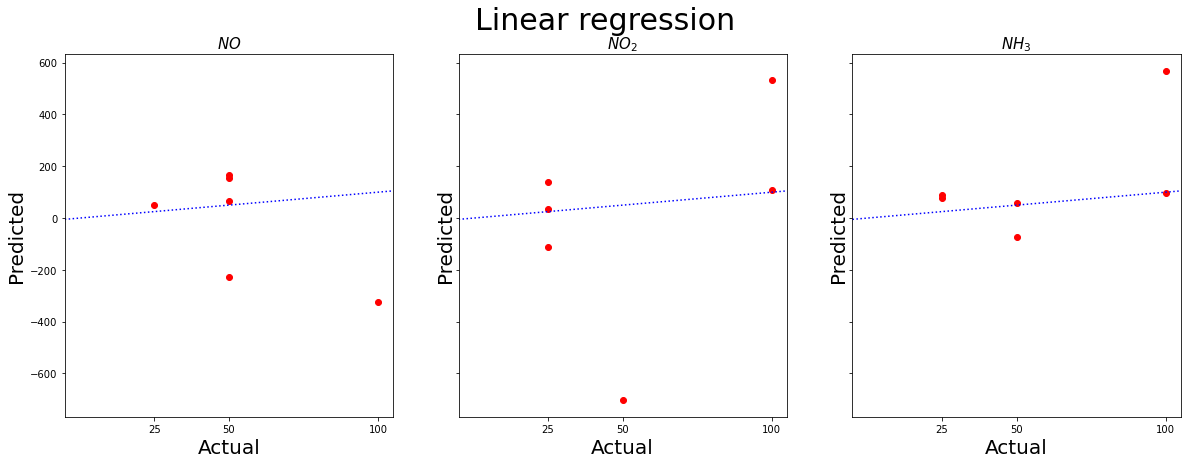

In [8]:
steps = [('poly', PolynomialFeatures()),
         ('linreg', LinearRegression())]

params = [{'poly__degree':list(range(1,4))}]

lr_pipe = Pipeline(steps)

lr_search = GridSearchCV(lr_pipe,
                         params,
                         scoring = 'neg_root_mean_squared_error',
                         return_train_score=True)

# Fitting to training data (test is in LOO)
lr_search.fit(X_train, y_train)
print(lr_search.best_params_)
print(lr_search.best_score_)
plot_actual_vs_pred(y_val, lr_search.best_estimator_.predict(X_val), 'Linear regression')

In [9]:
# # Scores
# test_scores = lr_search.cv_results_['mean_test_score'] * -1 
# train_scores = lr_search.cv_results_['mean_train_score'] * -1

# # Plotting
# plt.figure(figsize=(10, 7), dpi=200)
# plt.plot([1, 2, 3, 4] ,test_scores, label='Test')
# plt.plot([1, 2, 3, 4], train_scores, label='Train')
# plt.suptitle('Linear regression', fontsize=30)
# plt.title('RMSE - Polynomial degree', fontsize = 20)
# plt.xlabel('Degree', fontsize = 20)
# plt.ylabel('RMSE', fontsize = 20)
# plt.xticks([1, 2, 3, 4])
# plt.legend(loc='best')
# plt.show()

# Principal Components Regression - PCR

In [10]:
steps = [('scalar', StandardScaler()),
         ('PCA', PCA()),
         ('poly', PolynomialFeatures()),
         ('linreg', LinearRegression())]

params = [{'PCA__n_components':list(range(1,5)),
           'poly__degree':list(range(1,4))}]

pcr_pipe = Pipeline(steps)

pcr_search = GridSearchCV(pcr_pipe,
                      params,
                      scoring = 'neg_root_mean_squared_error',
                      return_train_score=True)

pcr_search.fit(X_train, y_train)
print(pcr_search.best_params_)
print(pcr_search.best_score_)

{'PCA__n_components': 1, 'poly__degree': 1}
-53.730303103946355


In [11]:
# test_scores = pcr_search.cv_results_['mean_test_score'] 
# train_scores = pcr_search.cv_results_['mean_train_score']

# plt.plot(test_scores, label='test')
# plt.plot(train_scores, label='train')
# plt.legend(loc='best')
# plt.show()

# Partial Least Squares Regression - PLSR

In [12]:
plsr_steps = [('poly', PolynomialFeatures()),
              ('PLSR', PLSRegression())]


plsr_params = [{'PLSR__n_components':list(range(1,14)),
                'poly__degree':list(range(1,4))}]

plsr_pipe = Pipeline(plsr_steps)

plsr_search = GridSearchCV(plsr_pipe,
                           plsr_params,
                           scoring = 'neg_root_mean_squared_error',
                           n_jobs = -1,
                           return_train_score=True)

plsr_search.fit(X_train, y_train)
print(plsr_search.best_params_)
print(plsr_search.best_score_)

{'PLSR__n_components': 1, 'poly__degree': 1}
-288.42022704464614


In [13]:
# test_scores = plsr_search.cv_results_['mean_test_score'] 
# train_scores = plsr_search.cv_results_['mean_train_score'] 

# plt.plot(test_scores, label='test')
# plt.plot(train_scores, label='train')
# plt.legend(loc='best')
# plt.show()

# Ridge Regression

In [14]:
from sklearn.linear_model import Ridge

ridge_steps = [('ridge', Ridge(solver= 'svd'))]

ridge_params = [{'ridge__alpha': np.arange(1000, 2000, 1)} ]

ridge_pipe = Pipeline(ridge_steps)

ridge_search = GridSearchCV(ridge_pipe,
                           ridge_params,
                           scoring = 'neg_root_mean_squared_error',
                           n_jobs = -1,
                           return_train_score=True)

ridge_search.fit(X_train, y_train)
print(ridge_search.best_params_)
print(ridge_search.best_score_)

{'ridge__alpha': 1999}
-43.98680650934725


# Plotting

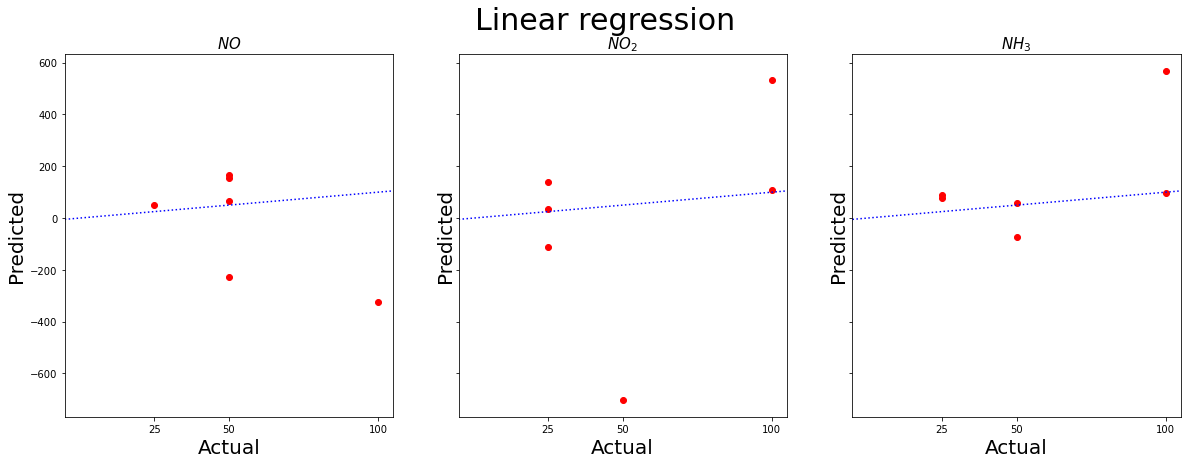

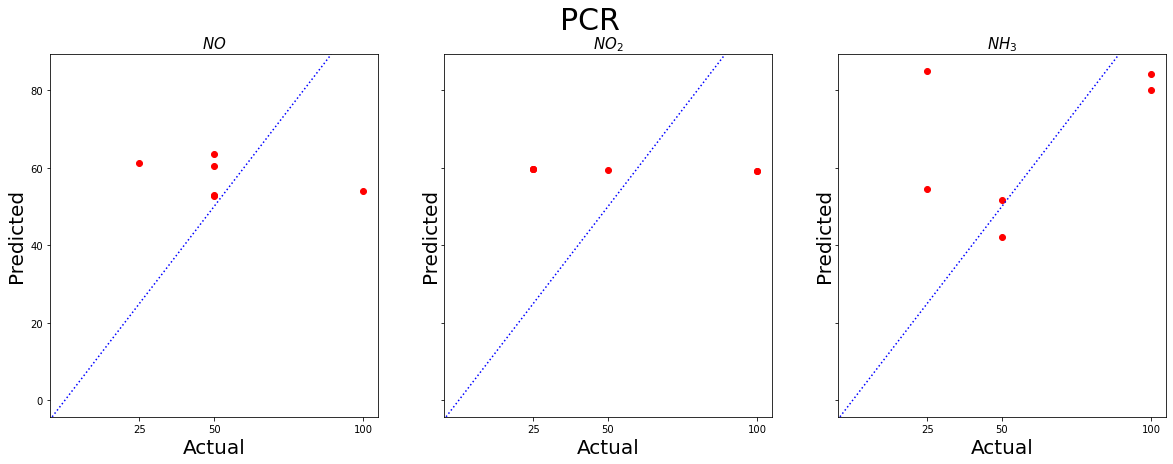

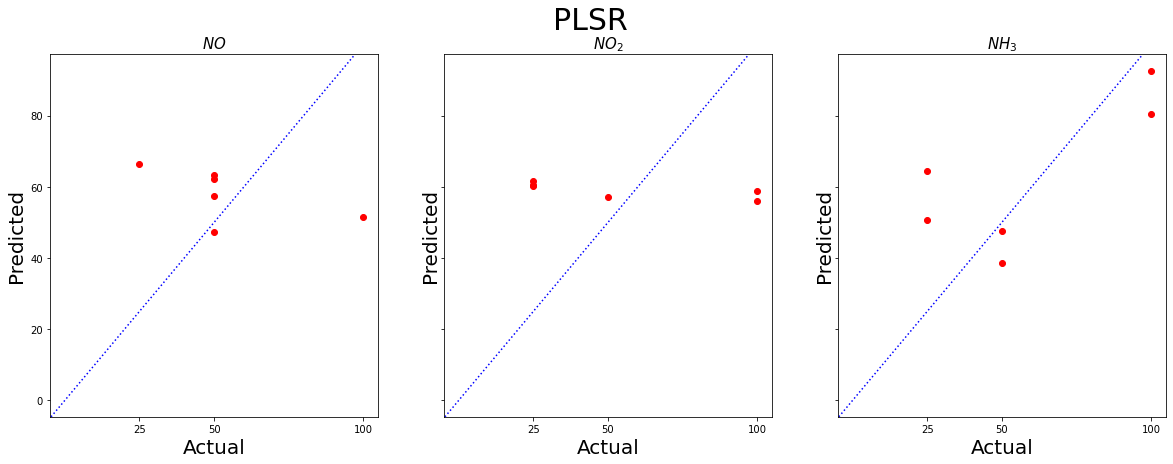

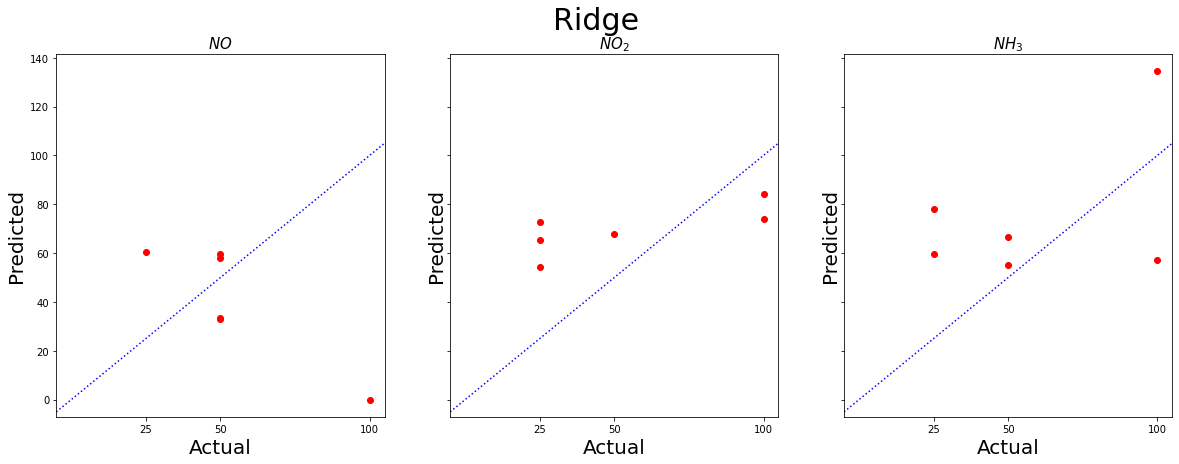

In [15]:
plot_actual_vs_pred(y_val, lr_search.best_estimator_.predict(X_val), 'Linear regression', save = True, filename= 'lr_plot')
plot_actual_vs_pred(y_val, pcr_search.best_estimator_.predict(X_val), 'PCR', save = True, filename= 'pcr_plot')
plot_actual_vs_pred(y_val, plsr_search.best_estimator_.predict(X_val), 'PLSR', save = True, filename= 'plsr_plot')
plot_actual_vs_pred(y_val, ridge_search.best_estimator_.predict(X_val), 'Ridge', save = True, filename= 'ridge_plot')
